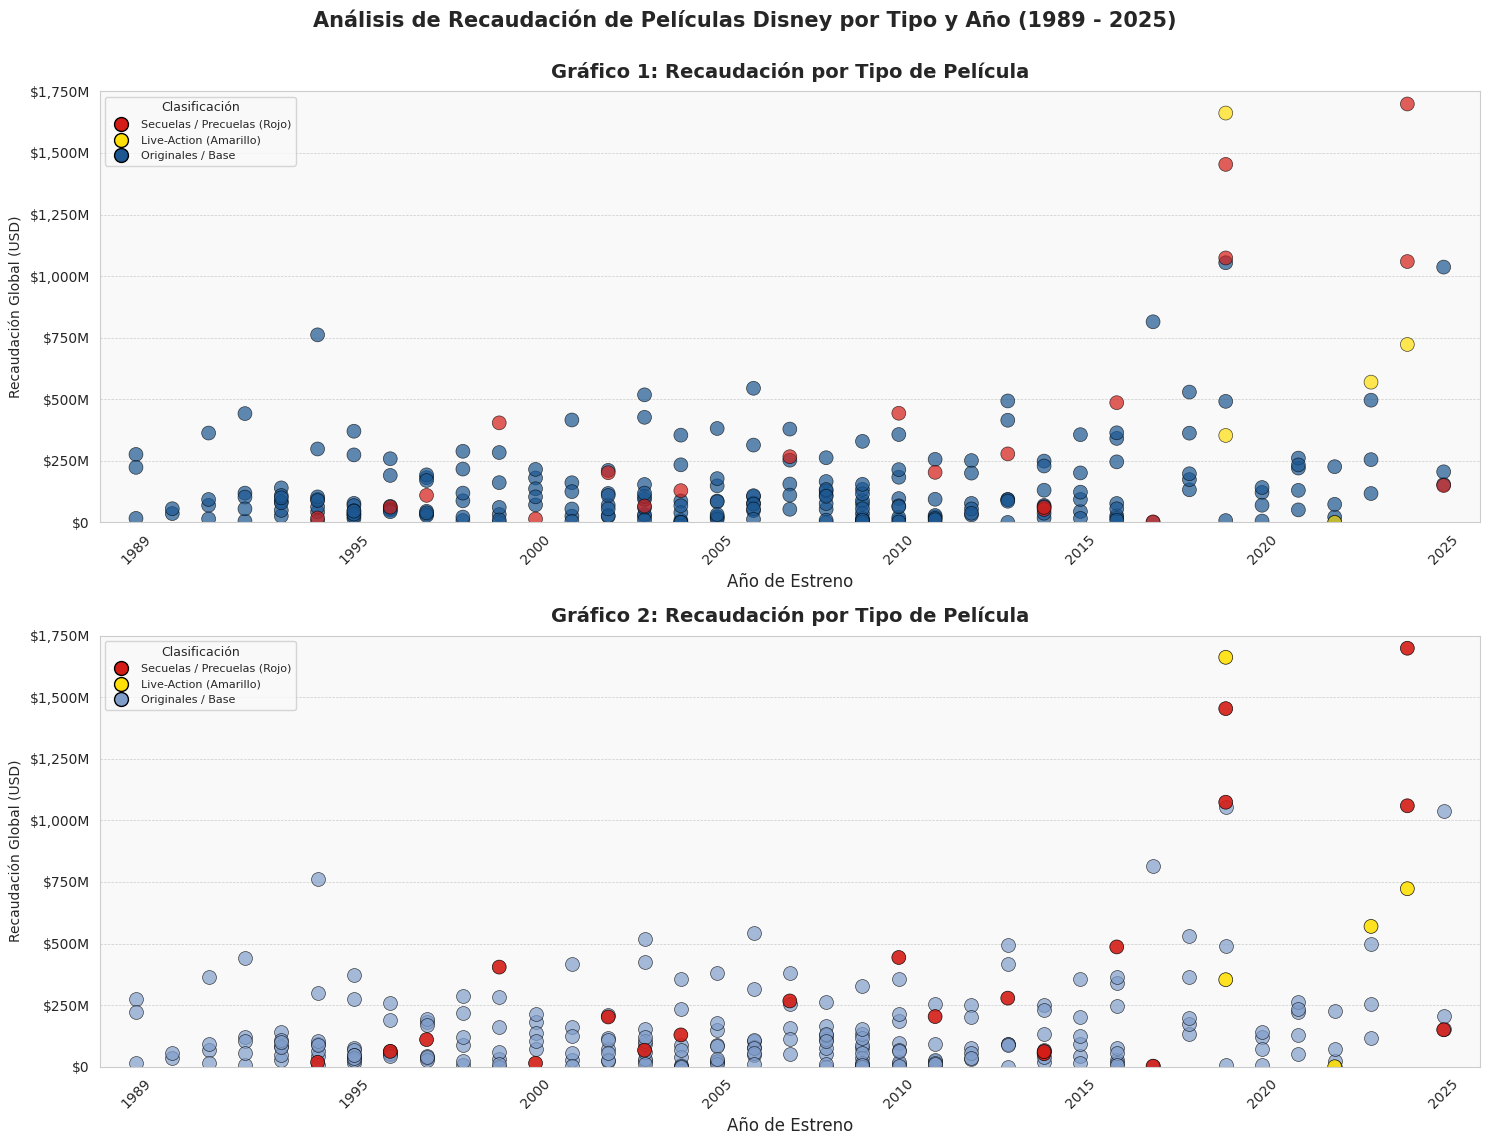

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, FixedLocator
import numpy as np
import seaborn as sns

file_name = 'recaudación_películas DISNEY.csv'

try:
    df = pd.read_csv(file_name, sep=';', encoding='utf-8-sig')
except Exception as e:
    print(f"Error al cargar el archivo: {e}")
    raise

df.columns = df.columns.str.strip().str.replace('\r', '', regex=False)

COL_TITULO = 'Título en español'
COL_RECAUDACION = '$ Recaudación'
COL_FECHA = 'Fecha de estreno'

df[COL_RECAUDACION] = pd.to_numeric(
    df[COL_RECAUDACION].astype(str).str.replace('.', '', regex=False),
    errors='coerce'
)

df[COL_FECHA] = pd.to_numeric(df[COL_FECHA], errors='coerce').astype('Int64')

df_filtrado = df.dropna(subset=[COL_RECAUDACION]).copy()
ANIO_INICIO = 1989
ANIO_FIN = 2025

df_final = df_filtrado[
    (df_filtrado[COL_FECHA] >= ANIO_INICIO) & (df_filtrado[COL_FECHA] <= ANIO_FIN)
].copy()

df_final = df_final.sort_values(by=COL_FECHA).reset_index(drop=True)

COLOR_ORIGINAL = '#1c5791'
COLOR_SECUELA = '#D41C16'
COLOR_LIVE_ACTION = '#ffdf07'
COLOR_BASE_GRAFICO2 = '#809dca'

COLOR_MAP = {
    'Original': COLOR_ORIGINAL,
    'Secuela/Precuela': COLOR_SECUELA,
    'Live-Action': COLOR_LIVE_ACTION,
    'Base': COLOR_BASE_GRAFICO2
}

live_action_titles = ['Alicia en el País de las Maravillas', 'El Rey León', 'La Bella y la Bestia', 'Aladdin', 'Mulan', 'Dumbo', 'El Libro de la Selva', 'Peter Pan & Wendy', 'Pinocho', 'La Sirenita']
secuela_titles = ['Toy Story 2', 'Toy Story 3', 'Toy Story 4', 'Los Increíbles 2', 'Buscando a Dory', 'Frozen II', 'Ralph rompe Internet', 'Monsters University', 'Cars 2', 'Cars 3', 'Intensa Mente 2', 'Moana 2']

def clasificar_pelicula(titulo):
    titulo_limpio = titulo.split('/')[0].strip()
    if any(la in titulo_limpio for la in live_action_titles):
        return 'Live-Action'
    if any(seq in titulo_limpio for seq in secuela_titles) or (' 2' in titulo_limpio) or (' II' in titulo_limpio):
        return 'Secuela/Precuela'
    return 'Original'

df_final['Tipo_Pelicula'] = df_final[COL_TITULO].apply(clasificar_pelicula)

condicion_ff2 = df_final[COL_TITULO].str.lower().str.contains('freaky friday', na=False) & \
                (df_final[COL_TITULO].str.lower().str.contains(' 2| ii|secuela', na=False))

df_final.loc[condicion_ff2, 'Tipo_Pelicula'] = 'Secuela/Precuela'
# ------------------------------------------------------------------
df_final['Color_G1'] = df_final['Tipo_Pelicula'].apply(lambda x: COLOR_MAP[x])


def asignar_color_g2(tipo):
    if tipo == 'Live-Action' or tipo == 'Secuela/Precuela':
        return COLOR_MAP[tipo]
    return COLOR_BASE_GRAFICO2

df_final['Color_G2'] = df_final['Tipo_Pelicula'].apply(asignar_color_g2)

def format_millions(x, pos):

    if x == 0:
        return '$0'
    return f'${x*1e-6:,.0f}M'

formatter = FuncFormatter(format_millions)


X_TICK_LOCATOR = [1989, 1995, 2000, 2005, 2010, 2015, 2020, 2025]


def get_y_ticks(data_max):
    """Genera los ticks del eje Y: 0, 50M, 100M, 250M, luego +250M."""

    if data_max >= 2_000_000_000:
        step = 500_000_000
    elif data_max >= 500_000_000:
        step = 250_000_000
    else:
        step = 100_000_000

    custom_ticks = [0]
    next_tick = step

    while next_tick <= data_max * 1.1:
        custom_ticks.append(next_tick)
        next_tick += step

    return sorted(list(set(custom_ticks)))

def crear_grafico_dispersion_final(ax, df_data, col_color, title, is_g1):
    """Crea un gráfico de dispersión con una lógica de trazado simplificada."""

    df_sorted = df_data.sort_values(by='Tipo_Pelicula', key=lambda x: x.map({'Original': 0, 'Secuela/Precuela': 1, 'Live-Action': 2}))

    if is_g1:
        ax.scatter(
            df_sorted[COL_FECHA],
            df_sorted[COL_RECAUDACION],
            c=df_sorted[col_color],
            s=100,
            alpha=0.7,
            edgecolors='black',
            linewidths=0.5
        )
    else:

        df_base = df_sorted[df_sorted['Tipo_Pelicula'] == 'Original']
        ax.scatter(
            df_base[COL_FECHA],
            df_base[COL_RECAUDACION],
            c=COLOR_BASE_GRAFICO2,
            s=100,
            alpha=0.7,
            edgecolors='black',
            linewidths=0.5,
            label='Películas Base'
        )


        df_destacado = df_sorted[df_sorted['Tipo_Pelicula'] != 'Original']
        ax.scatter(
            df_destacado[COL_FECHA],
            df_destacado[COL_RECAUDACION],
            c=df_destacado[col_color],
            s=100,
            alpha=0.9,
            edgecolors='black',
            linewidths=0.5
        )

    ax.yaxis.set_major_formatter(formatter)

    max_recaudacion = df_data[COL_RECAUDACION].max()
    y_ticks = get_y_ticks(max_recaudacion)
    ax.yaxis.set_major_locator(FixedLocator(y_ticks))
    ax.set_ylim(0, y_ticks[-1])

    ax.xaxis.set_major_locator(FixedLocator(X_TICK_LOCATOR))

    ax.tick_params(axis='x', rotation=45)
    ax.set_xlim(1988, 2026)

    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)

    ax.set_ylabel('Recaudación Global (USD)', fontsize=10)
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, axis='y')
    ax.xaxis.grid(False)

    ax.set_xlabel('Año de Estreno', fontsize=12)

    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label='Secuelas / Precuelas (Rojo)',
                   markerfacecolor=COLOR_SECUELA, markersize=10, markeredgecolor='black'),
        plt.Line2D([0], [0], marker='o', color='w', label='Live-Action (Amarillo)',
                   markerfacecolor=COLOR_LIVE_ACTION, markersize=10, markeredgecolor='black'),
        plt.Line2D([0], [0], marker='o', color='w', label='Originales / Base',
                   markerfacecolor=COLOR_ORIGINAL if is_g1 else COLOR_BASE_GRAFICO2,
                   markersize=10, markeredgecolor='black'),
    ]

    ax.legend(handles=legend_elements, loc='upper left', title="Clasificación", fontsize=8, title_fontsize=9)


sns.set_style("whitegrid")
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = '#f9f9f9'


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 12), sharex=False)
plt.subplots_adjust(hspace=0.35)


fig.suptitle(
    'Análisis de Recaudación de Películas Disney por Tipo y Año (1989 - 2025)',
    fontsize=15,
    fontweight='bold'
)


crear_grafico_dispersion_final(
    axes[0],
    df_final,
    'Color_G1',
    f'Gráfico 1: Recaudación por Tipo de Película',
    is_g1=True
)


crear_grafico_dispersion_final(
    axes[1],
    df_final,
    'Color_G2',
    f'Gráfico 2: Recaudación por Tipo de Película',
    is_g1=False
)


plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()